# Using a pretrained image captioning model
We will be using Hugging Face's `transformers` package to get access to pre-trained image processing and language models. We will instantiate a pre-trained architecture and get predictions for arbitrary inputs.

In [1]:
# import required libraries
from transformers import GPT2TokenizerFast, ViTImageProcessor, VisionEncoderDecoderModel
import requests
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

We need to import the general `VisionEncoderDecoderModel` module from the `transformers` package, as well as the tokenizer (`GPT2TokenizerFast`) for the decoder and the image processor (`ViTImageProcessor`) for the encoder component. The `requests` package allows us to open pictures from URLs.

## Loading the pre-trained model and it's helper components
We load the pre-trained neural image captioner like so:

In [2]:
model_raw = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

In order to be able to feed this image+language model with images and language, we need an image processor and a tokenizer that fits the model components used for encoding and decoding.

In [3]:
image_processor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer       = GPT2TokenizerFast.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

## Generating captions
You can insert URLs for pictures of your liking in this code to generate captions:

In [4]:
def show_n_generate(url, greedy = True, model = model_raw):
    image = Image.open(requests.get(url, stream =True).raw)
    pixel_values   = image_processor(image, return_tensors ="pt").pixel_values
    plt.imshow(np.asarray(image))
    plt.show()

    if greedy:
        generated_ids  = model.generate(pixel_values, max_new_tokens = 30)
    else:
        generated_ids  = model.generate(
            pixel_values,
            do_sample=True,
            max_new_tokens = 30,
            top_k=5)
    generated_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    print(generated_text)

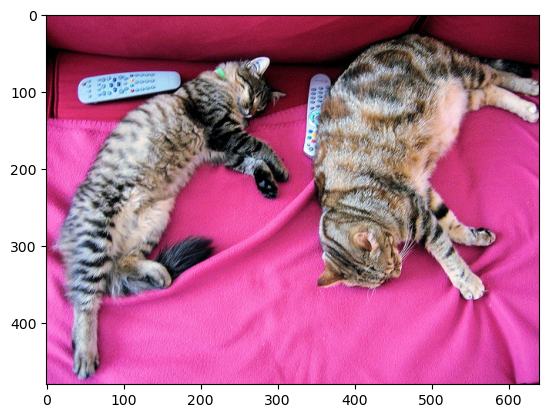

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


a cat and a cat laying on a blanket 


In [5]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"

show_n_generate(url, greedy = False)

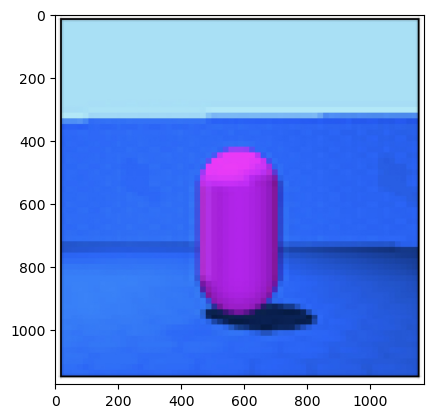

a pink toy in front of some blue glass 


In [6]:
url = "https://raw.githubusercontent.com/michael-franke/npNLG/main/neural_pragmatic_nlg/pics/06-3DS-example.jpg"

show_n_generate(url, greedy = False)

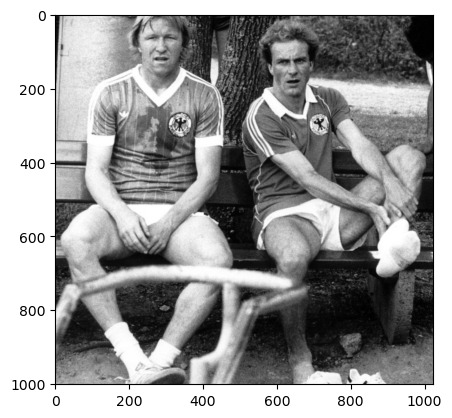

two people sit on bench with one holding an empty tennis racket 


In [7]:
url = "https://img.welt.de/img/sport/mobile102025155/9292509877-ci102l-w1024/hrubesch-rummenigge-BM-Berlin-Gijon-jpg.jpg"

show_n_generate(url, greedy = False)

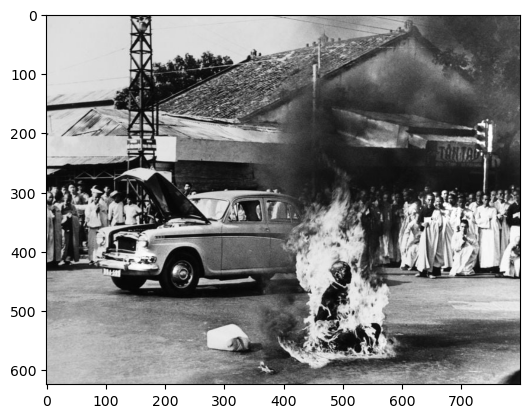

an old fashioned truck is shown on the street 


In [8]:
url = "https://faroutmagazine.co.uk/static/uploads/2021/09/The-Cover-Uncovered-The-severity-of-Rage-Against-the-Machines-political-message.jpg"

show_n_generate(url, greedy = False)

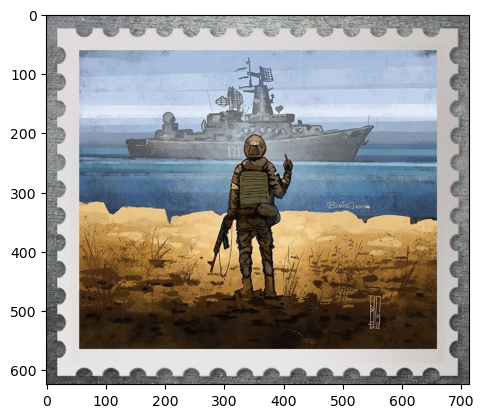

a man is posing on a painting of a sea 


In [9]:
url = "https://media.npr.org/assets/img/2022/03/13/2ukraine-stamp_custom-30c6e3889c98487086d76869f8ba6a8bfd2fd5a1.jpg"

show_n_generate(url, greedy = False)

# Training an image captioning model

## Getting the Flickr8K dataset
We downloaded the dataset ahead of time and stored it in the `dataset/` directory. This is a good dataaset to get started with image capationing because it is realistic and relatively small such that you can download it and build models on your PC. It is comprised of more than 8000 images and up to 5 captions for each photo.

## Loading the images and pre-calculating image features
The image file names are unique identifiers. For example, here's a sample of image file names:
```bash
990890291_afc72be141.jpg
99171998_7cc800ceef.jpg
99679241_adc853a5c0.jpg
997338199_7343367d7f.jpg
997722733_0cb5439472.jpg
```
In this section we will:
- load the images from the Flickr8k dataset
- preprocess them using the Keras to prepare them for the VGG model
- extract features from the images and store them in a dictionary using the images' unique identifies as the key
- store the dictionary in a file so these features can then be loaded later and used as input for training a language model.

The reason for extracting the extracting the image features and storing them in a file ahead of time is mainly for efficiency. This means that the language part of the model that turns the extracted image features into textual descriptions can be trained standalone from the feature extraction model. The benefitt is that the very large pre-trained models do not need to be loaded, held in memory, and used to process each photo while training the language model.

Later, the feature extraction model and language model can be put back together for making predictions on new photos.

In [10]:
# importing required libraries
from os import listdir
from os import path
from pickle import dump
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input

In [11]:
# create a function to load the images from the filesystem and extract features
# from them
def extract_features(directory):
  # load the model
  input_layer = Input(shape=(224, 224, 3))
  model = VGG16(include_top=False, input_tensor=input_layer)
  model.summary()

  # extract features from each photo
  features = dict()
  for name in listdir(directory):
    # load an image from file
    filename = path.join(directory, name)
    image = load_img(filename, target_size=(224, 224)) # why the (224, 224) size?

    # convert the image pixels into a numpy array
    image = img_to_array(image)

    # reshape the data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2])) # why?

    # prepare the image for the VGG model
    image = preprocess_input(image)

    # get the features
    feature = model.predict(image, verbose=0)

    # get the image id
    image_id = name.split(".")[0]
    features[image_id] = feature

  return features

In [12]:
# extract features from all images using the created function
directory = "dataset/Images"
features = extract_features(directory)
print('Extracted Features: %d' % len(features))

58889256/58889256 [==============================] - 64s 1us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                             

In [13]:
# Store the features in a file on Google drive
dump(features, open('dataset/features.pkl', 'wb'))

## Loading and preprocessing the image descriptions
A sample of the contents of the image descriptions file (`captions.txt`) looks like this:
```bash
1305564994_00513f9a5b.jpg#0 A man in street racer armor be examine the tire of another
racer 's motorbike .
1305564994_00513f9a5b.jpg#1 Two racer drive a white bike down a road .
1305564994_00513f9a5b.jpg#2 Two motorist be ride along on their vehicle that be oddly
design and color .
1305564994_00513f9a5b.jpg#3 Two person be in a small race car drive by a green hill .
1305564994_00513f9a5b.jpg#4 Two person in race uniform in a street car .
```
The file contains a list of image identifiers (used in the image filenames) and tokenized descriptions. Each image contains 5 descriptions. We will only use the first one.

In [14]:
# create a function that loads the entire descriptions document into memory
def load_doc(filename):
  # open the file as read only
  file = open(filename, 'r')

  # read all the text in the file
  text = file.read()

  # close the file
  file.close()
  return text

In [15]:
# create function to extract extract the descriptions for images
def load_descriptions(doc):
  mapping = dict()
  for line in doc.split('\n'):
    # split the line by white space
    tokens = line.split()
    if len(line) < 2:
      continue

    # take the first token as the image id and the rest as the image description
    image_id, image_desc = tokens[0], tokens[1:]

    # remove the filename from the image id
    image_id = image_id.split('.')[0]

    # convert description tokens back to string
    image_desc = ' '.join(image_desc)

    # store the first description for each image since each image has a 5 descriptions
    if image_id not in mapping:
      mapping[image_id] = image_desc

  return mapping

### Preparing the description text
In this section we will:
- Normalize the case of all the tokens to lowercase
- Remove punctuation from tokens
- Remove all tokens that container one or fewer characters (after punctuation is removed)

In [16]:
#  required libraries
import string
import re

In [17]:
# create a function to clean up the descriptions
def clean_descriptions(descriptions):
  # prepare regex for char filtering
  re_punc = re.compile('[%s]' % re.escape(string.punctuation))

  for key, desc in descriptions.items():
    # tokenize
    desc = desc.split()

    # convert to lower case
    desc = [word.lower() for word in desc]

    # remove punctuation from each word
    desc = [re_punc.sub('', w) for w in desc]

    # remove hanging 's' and 'a'
    desc = [word for word in desc if len(word)>1]

    # store as string
    descriptions[key] = ' '.join(desc)

In [18]:
# create a function to save descriptions to file, one per line
def save_doc(descriptions, filename):
  lines = list()
  for key, desc in descriptions.items():
    lines.append(key + ' ' + desc)
  data = '\n'.join(lines)
  file = open(filename, 'w')
  file.write(data)
  file.close()

### Putting it all together

In [19]:
filename = 'dataset/captions.txt'

# load descriptions
doc = load_doc(filename)

# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

# clean descriptions
clean_descriptions(descriptions)

# summarize vocabulary
all_tokens = ' '.join(descriptions.values()).split()
vocabulary = set(all_tokens)
print('Vocabulary Size: %d' % len(vocabulary))

# save descriptions
save_doc(descriptions, 'dataset/descriptions.txt')

Loaded: 8092 
Vocabulary Size: 4465


## Creating a word-by-word model
This type of model generates a caption for an image one word at a time given both the image as input and the last word generated. This model would then have to be called recursively to generate each word in the description with previous predictions as input.

A word-by-word model is simpler compared to a **whole description sequence model** which would output the entire textual description for an image in one go, which puts a heavy burden on the model to both interpret the meaning of the photograph and generate words, then arrange those words in the correct order.

We can use tools in Keras to prepare the descriptions for this type of model.

In [23]:
# Required libraries
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [24]:
# load doc into memory
def load_doc(filename):
  # open the file as read only
  file = open(filename, 'r')

  # read all text
  text = file.read()

  # close the file
  file.close()

  return text

In [25]:
# create a function to load clean image descriptions previously created
# load clean descriptions into memory
def load_clean_descriptions(filename):
  doc = load_doc(filename)

  descriptions = dict()
  for line in doc.split('\n'):
    # split line by white space
    tokens = line.split()

    # split id from description
    image_id, image_desc = tokens[0], tokens[1:]

    # store
    descriptions[image_id] = ' '.join(image_desc)
  return descriptions

In [29]:
# use the helper functions
filename = "dataset/descriptions.txt"
descriptions = load_clean_descriptions(filename)

# extract all the text of the descriptions
# these will be used to build a vocabulary for the Tokenizer()
desc_text = list(descriptions.values())

# prepare the tokenizer, fit it on the description texts for that it
# learn a vocabulary i.e. build a vocabulary and generate word-to-index mappings.
tokenizer = Tokenizer()
tokenizer.fit_on_texts(desc_text)

In [32]:
# what do the descriptions look like?
desc_text[:5]

['',
 'child in pink dress is climbing up set of stairs in an entry way',
 'black dog and spotted dog are fighting',
 'little girl covered in paint sits in front of painted rainbow with her hands in bowl',
 'man lays on bench while his dog sits by him']

In [30]:
# get the size of the learned vocabulary
# The "+1" accounts for an additional index that is typically reserved for out-of-vocabulary words.
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

Vocabulary Size: 4466


In [31]:
# integer encode the textual descriptions to convert them to integer sequences
# due to the tokenizer, each word in the vocabulary was assigned a unique ID
# these ID will be used to make the sequences
sequences = tokenizer.texts_to_sequences(desc_text)
sequences[:5]

[[],
 [35, 1, 63, 140, 5, 121, 50, 403, 7, 363, 1, 28, 2342, 517],
 [10, 6, 3, 747, 6, 15, 364],
 [47, 13, 166, 1, 577, 97, 1, 38, 7, 545, 1193, 9, 53, 210, 1, 1070],
 [8, 615, 4, 147, 23, 20, 6, 97, 42, 109]]

In [33]:
# add padding to the sequences so that they are of the same length
# this is because NN models expect fixed length inputs unlike other models in NLP
max_length = max(len(s) for s in sequences)
print('Description Length: %d' % max_length)

padded = pad_sequences(sequences, maxlen=max_length, padding="post")
padded[:5]

Description Length: 28


array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [  35,    1,   63,  140,    5,  121,   50,  403,    7,  363,    1,
          28, 2342,  517,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [  10,    6,    3,  747,    6,   15,  364,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [  47,   13,  166,    1,  577,   97,    1,   38,    7,  545, 1193,
           9,   53,  210,    1, 1070,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [   8,  615,    4,  147,   23,   20,    6,   97,   42,  109,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0]])

In [34]:
# one hot encode the padded sequences. Why?
y = to_categorical(padded, num_classes=vocab_size)

y = y.reshape((len(descriptions), max_length, vocab_size))
print(y.shape)

(8092, 28, 4466)
